In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

# Set the data directory path
data_dir = 'path_to_your_dataset_directory'

# List all classes (folders) in the dataset directory
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Initialize a dictionary to store image counts per class
class_counts = {}

# Iterate through each class and its subdirectories
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    total_images = 0
    # Iterate through subdirectories (e.g., "default", "real_world")
    for sub_dir in os.listdir(class_dir):
        sub_dir_path = os.path.join(class_dir, sub_dir)
        if os.path.isdir(sub_dir_path):
            num_images = len(os.listdir(sub_dir_path))
            total_images += num_images
    class_counts[cls] = total_images

# Display the classes and their corresponding image counts
for cls, count in class_counts.items():
    print(f'Class: {cls}, Number of images: {count}')

In [47]:
# Define the paths
base_dir = 'images/images/'
train_dir = 'images/train/'
val_dir = 'images/val/'
test_dir = 'images/test/'

# Create directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Iterate through each waste category and split data
for category in os.listdir(base_dir):
    if category in ['default', 'real_world']:  # Skip these
        continue

    category_path = os.path.join(base_dir, category)

    # Iterate through each type (default, real_world)
    for img_type in ['default', 'real_world']:
        img_type_path = os.path.join(category_path, img_type)
        images = os.listdir(img_type_path)

        # Split the images into train, val, and test
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Create directories for this category in train, val, test sets
        train_category_dir = os.path.join(train_dir, category, img_type)
        val_category_dir = os.path.join(val_dir, category, img_type)
        test_category_dir = os.path.join(test_dir, category, img_type)

        for sub_dir in [train_category_dir, val_category_dir, test_category_dir]:
            os.makedirs(sub_dir, exist_ok=True)

        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(img_type_path, img), os.path.join(train_category_dir, img))
        for img in val_images:
            shutil.move(os.path.join(img_type_path, img), os.path.join(val_category_dir, img))
        for img in test_images:
            shutil.move(os.path.join(img_type_path, img), os.path.join(test_category_dir, img))

print("Data splitting completed successfully.")

Data splitting completed successfully.


In [80]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Validation and test data should not be augmented
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 10499 images belonging to 30 classes.
Found 2220 images belonging to 30 classes.
Found 2280 images belonging to 30 classes.


In [81]:
# Model Definition and Compilation
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(30, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\User\AppData\Local\Temp\ipykernel_23764\654913121.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


In [62]:
# Initial Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.3293 - loss: 2.5078 - val_accuracy: 0.6378 - val_loss: 1.1785
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 95s 285ms/step - accuracy: 0.5484 - loss: 1.5283 - val_accuracy: 0.6743 - val_loss: 1.0682
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 94s 282ms/step - accuracy: 0.5844 - loss: 1.3897 - val_accuracy: 0.6883 - val_loss: 1.0019
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 92s 276ms/step - accuracy: 0.6094 - loss: 1.2983 - val_accuracy: 0.6932 - val_loss: 0.9552
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 289ms/step - accuracy: 0.6254 - loss: 1.2240 - val_accuracy: 0.7045 - val_loss: 0.9205
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 92s 275ms/step - accuracy: 0.6274 - loss: 1.2223 - val_accuracy: 0.6901 - val_loss: 0.9528
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 93s 281ms/step - accuracy: 0.6426 - loss: 1.1343 - val_accuracy: 0.7162 - val_loss: 0.8865
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 95s 286ms/step - accuracy: 0.6470 - loss: 

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.keras', save_best_only=True, monitor='val_loss')

# Continue training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.5454 - loss: 1.5546 - val_accuracy: 0.7252 - val_loss: 0.9428
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 453ms/step - accuracy: 0.6180 - loss: 1.2435 - val_accuracy: 0.7324 - val_loss: 0.9327
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.6485 - loss: 1.1447 - val_accuracy: 0.7360 - val_loss: 0.9004
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.6711 - loss: 1.0346 - val_accuracy: 0.7342 - val_loss: 0.8791
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 452ms/step - accuracy: 0.6803 - loss: 1.0138 - val_accuracy: 0.7351 - val_loss: 0.8564
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 453ms/step - accuracy: 0.7055 - loss: 0.9454 - val_accuracy: 0.7419 - val_loss: 0.8345
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 453ms/step - accuracy: 0.7099 - loss: 0.9136 - val_accuracy: 0.7554 - val_loss: 0.8136
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 452ms/step - accuracy: 0.7118 -

In [83]:
# Load the best model
model.load_weights('cnn_best_model.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

d:\Recyclable_image_processing\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8174 - loss: 0.6391
Test Accuracy: 0.8258771896362305
Test Loss: 0.6214569807052612


72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step
Confusion Matrix
[[4 0 7 1 2 3 3 2 0 4 0 2 4 7 2 5 2 4 2 3 1 3 1 4 2 1 1 1 2 3]
 [1 2 3 0 3 3 1 2 2 4 3 1 3 2 3 4 2 3 5 5 3 1 2 4 1 3 4 4 0 2]
 [1 2 0 2 3 3 3 4 0 3 0 4 4 4 2 1 2 2 3 5 0 2 3 3 2 4 3 3 5 3]
 [2 3 5 1 0 1 5 3 4 1 0 2 2 2 3 1 2 3 1 2 2 1 5 8 4 2 4 2 2 3]
 [3 1 4 1 2 3 1 4 1 6 7 1 3 1 3 3 3 3 3 1 1 2 1 3 1 4 1 4 2 3]
 [5 0 1 3 1 4 2 2 5 4 4 2 2 4 2 2 2 4 2 2 6 0 5 4 2 2 0 0 3 1]
 [3 4 2 5 2 1 3 1 4 2 0 1 2 1 3 4 2 3 5 4 2 4 1 3 2 5 2 2 2 1]
 [1 1 3 6 3 1 4 4 6 3 1 1 1 2 1 3 2 2 0 1 1 4 4 3 5 2 4 3 1 3]
 [3 2 0 5 0 2 2 4 3 3 2 1 3 6 4 1 7 1 2 3 1 6 2 0 1 2 4 4 1 1]
 [1 1 1 4 5 5 2 1 2 2 3 2 1 3 7 4 6 3 2 1 1 1 5 1 5 1 3 0 2 1]
 [2 3 3 7 0 2 1 2 2 1 3 5 1 2 3 1 2 5 3 3 2 4 2 2 1 1 1 4 3 5]
 [2 1 3 5 2 1 2 0 2 0 1 3 4 5 3 2 2 1 3 3 7 1 1 1 4 6 1 5 4 1]
 [5 4 4 6 1 3 0 3 1 5 3 4 2 1 0 2 4 2 1 2 1 1 5 0 2 1 2 1 6 4]
 [1 3 5 4 1 6 5 2 2 2 3 4 1 2 3 3 1 2 2 0 4 3 4 2 2 4 1 2 0 2]
 [6 1 4 2 2 4 1 1 1 1 3 1 5 5 3 3 2 2 2 0 2 2 2 0 5 3 6 2 4

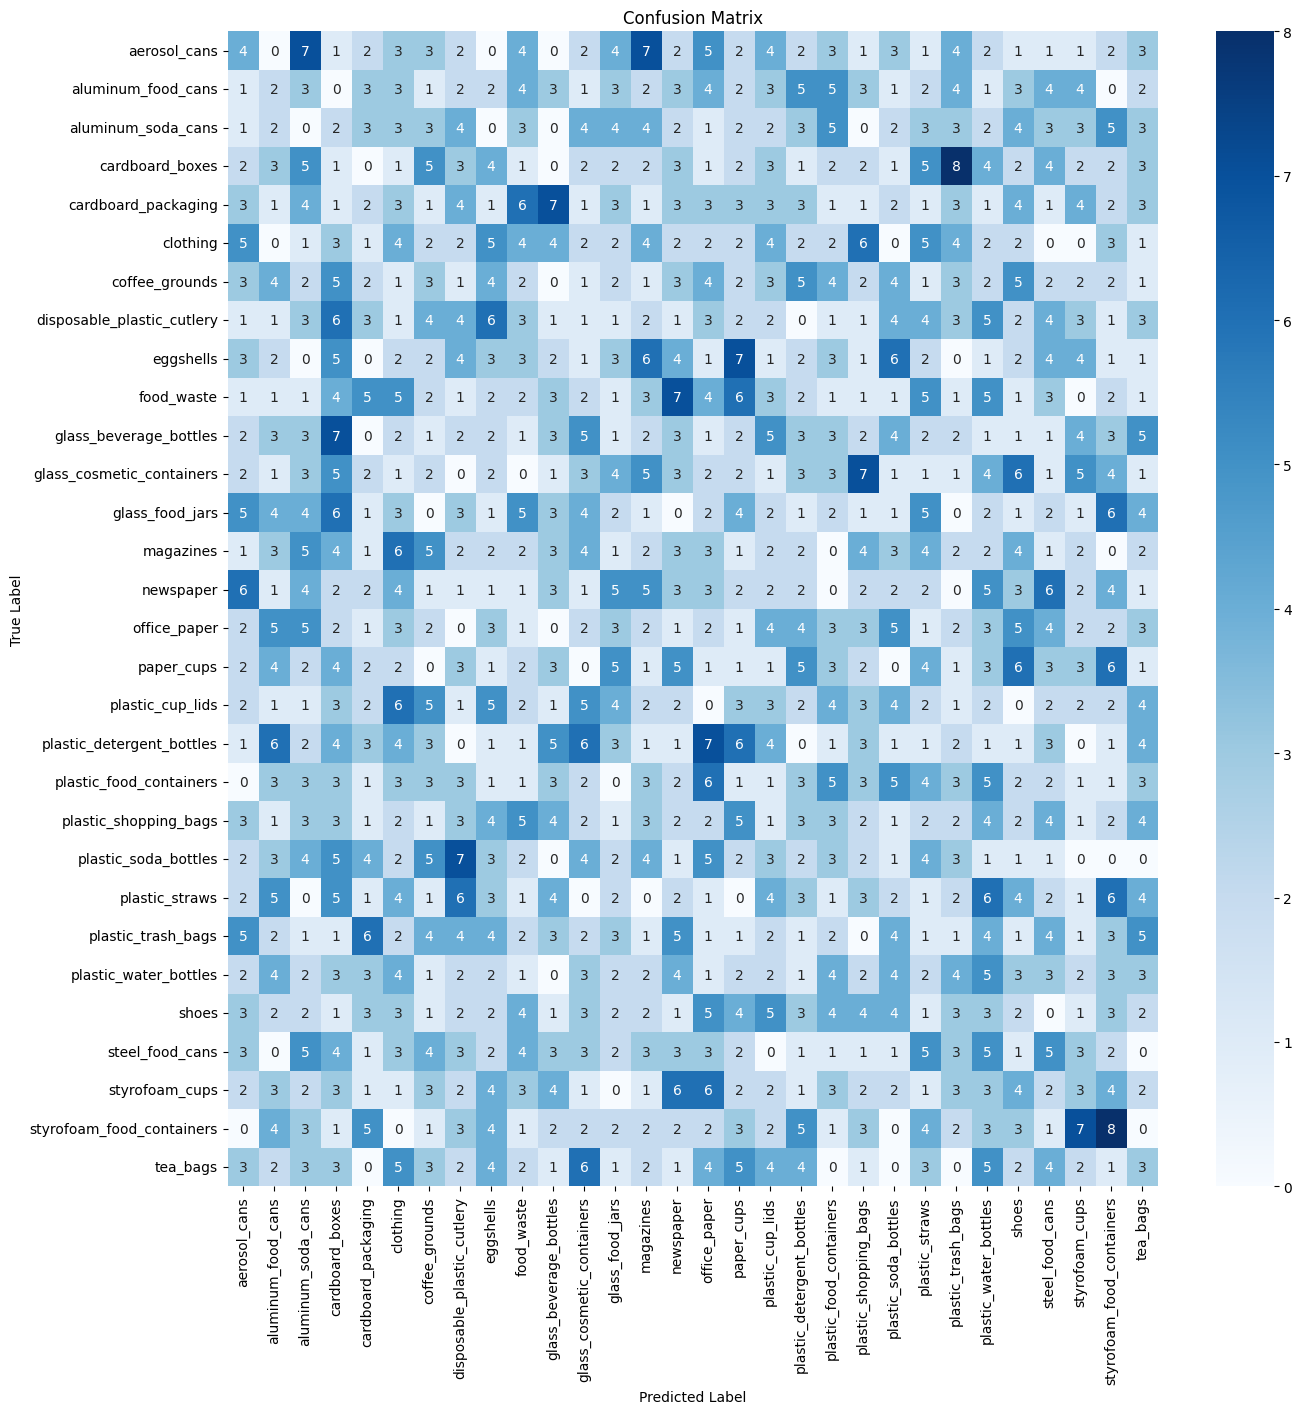

In [84]:
# Generate confusion matrix and classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Display confusion matrix as a heatmap
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the best model
model.load_weights('cnn_best_model.keras')

# Recompile the model with class weights
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Continue training with class weights
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 185s 472ms/step - accuracy: 0.8502 - loss: 0.4348 - val_accuracy: 0.8203 - val_loss: 0.6577
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 167s 502ms/step - accuracy: 0.8463 - loss: 0.4310 - val_accuracy: 0.8167 - val_loss: 0.6609
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 170s 511ms/step - accuracy: 0.8548 - loss: 0.4256 - val_accuracy: 0.8203 - val_loss: 0.6585
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 174s 524ms/step - accuracy: 0.8533 - loss: 0.4187 - val_accuracy: 0.8207 - val_loss: 0.6530
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 173s 522ms/step - accuracy: 0.8650 - loss: 0.4028 - val_accuracy: 0.8216 - val_loss: 0.6522
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 175s 527ms/step - accuracy: 0.8623 - loss: 0.4045 - val_accuracy: 0.8266 - val_loss: 0.6617
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 175s 526ms/step - accuracy: 0.8563 - loss: 0.4118 - val_accuracy: 0.8315 - val_loss: 0.6605
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 174s 525ms/step - accuracy: 0.8666 -

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history returned by model.fit
# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [85]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8256 - loss: 0.6295
Test Accuracy: 0.8258771896362305
Test Loss: 0.6214568614959717


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step


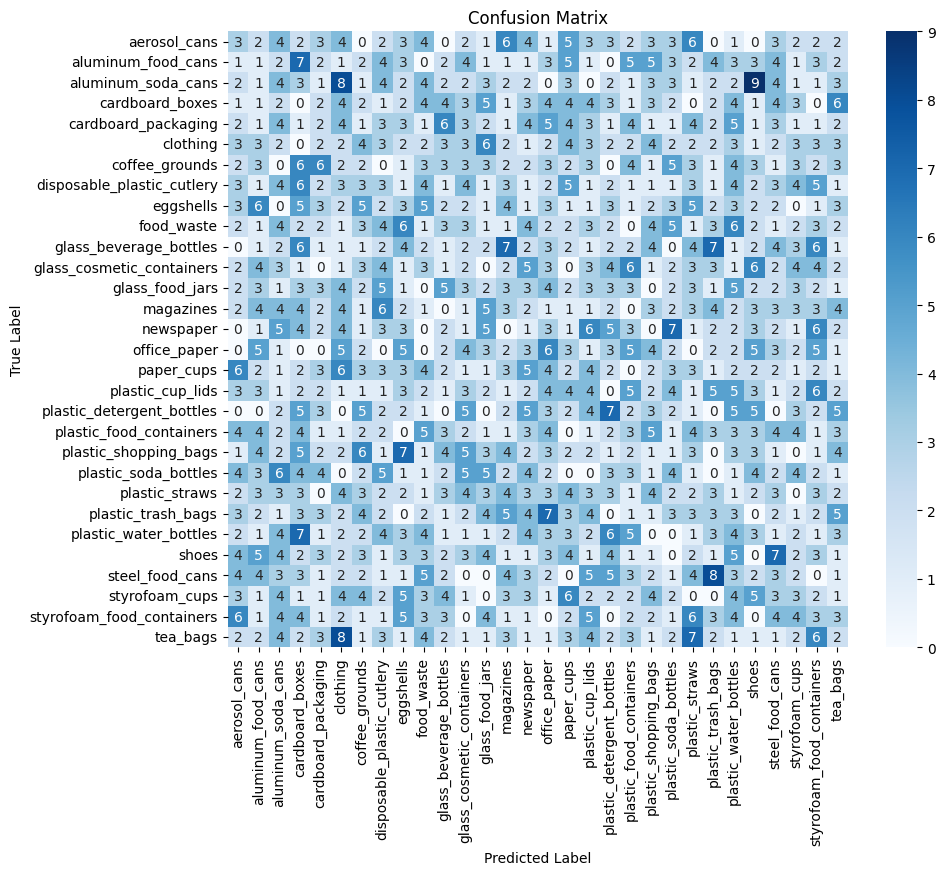

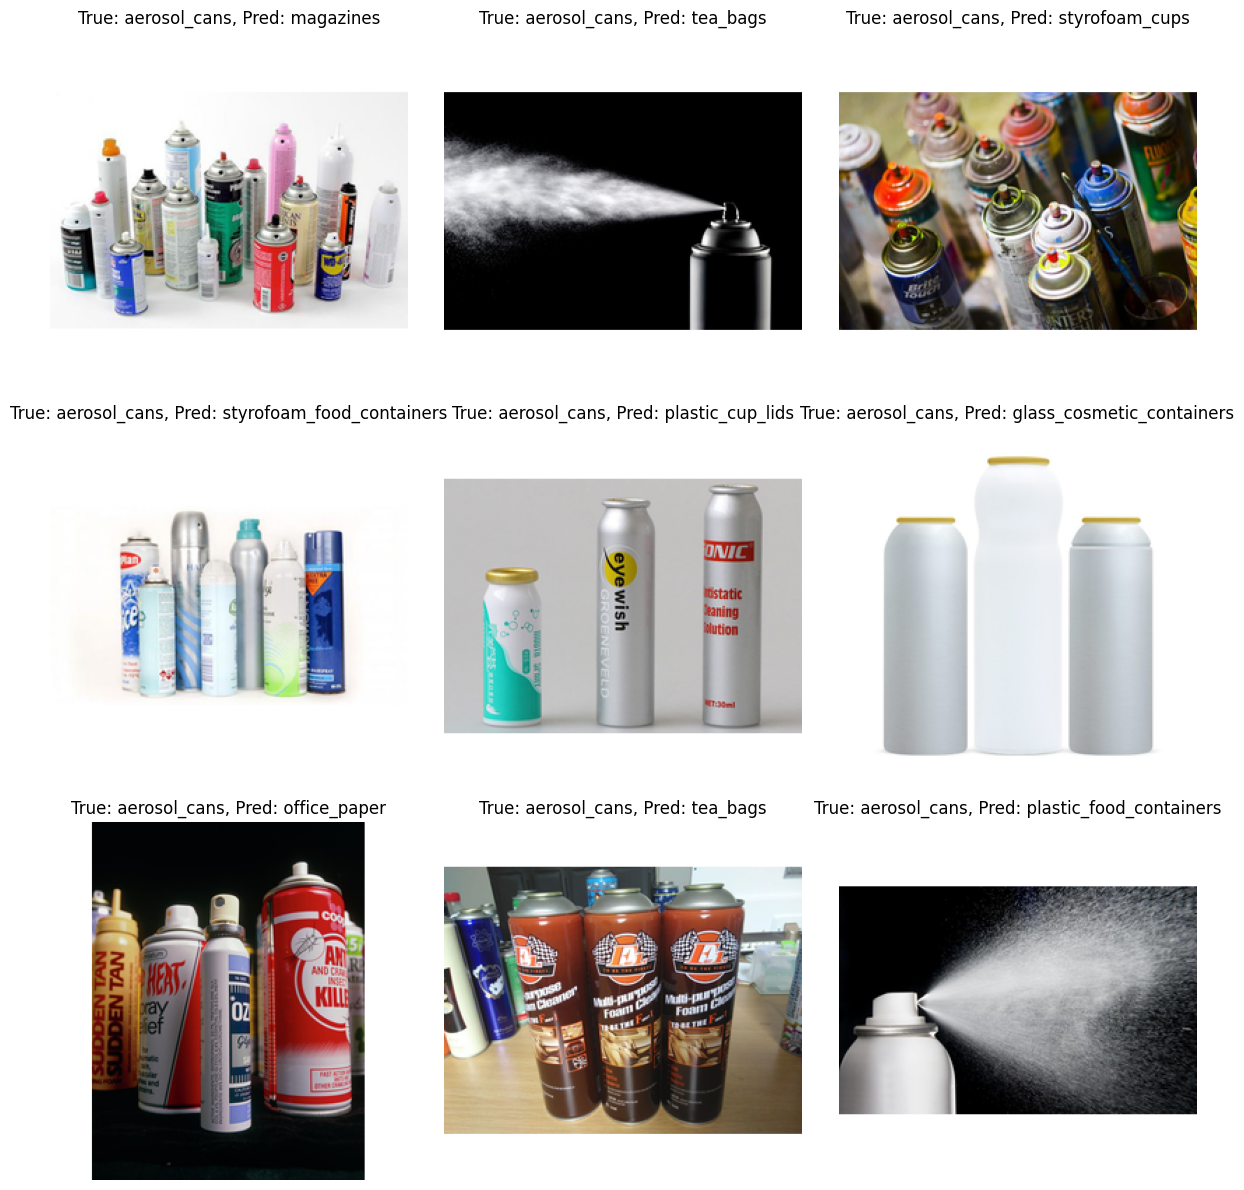

In [89]:
# Predict classes for the test set
Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get the misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Display some misclassified images
plt.figure(figsize=(12, 12))
for i, index in enumerate(misclassified_indices[:9]):
    # Get the path to the image
    image_path = test_generator.filepaths[index]
    img = Image.open(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    true_label = list(test_generator.class_indices.keys())[y_true[index]]
    predicted_label = list(test_generator.class_indices.keys())[y_pred_classes[index]]
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [90]:
import numpy as np

# Assuming y_true and y_pred_classes are already defined
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Extract misclassified file paths and labels
misclassified_files = []
misclassified_true_labels = []
misclassified_pred_labels = []

for idx in misclassified_indices:
    misclassified_files.append(test_generator.filepaths[idx])
    misclassified_true_labels.append(y_true[idx])
    misclassified_pred_labels.append(y_pred_classes[idx])

print(f"Number of misclassified samples: {len(misclassified_files)}")


Number of misclassified samples: 2203


In [94]:
# Directory for fine-tuning data
fine_tune_dir = 'fine_tune_data/'

# Ensure the directory exists
os.makedirs(fine_tune_dir, exist_ok=True)

# Misclassified indices already found
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Define the source of the misclassified samples
source_dir = 'images/test'  # Update this to your test image directory

# Move the misclassified images to the fine-tune directory
for idx in misclassified_indices:
    class_label = test_generator.classes[idx]
    class_name = list(test_generator.class_indices.keys())[class_label]
    img_name = test_generator.filenames[idx]
    
    # Create class directory in fine-tune data
    class_dir = os.path.join(fine_tune_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    # Construct full path to the image
    full_img_path = os.path.join(source_dir, img_name)
    
    # Ensure the image exists before moving
    if os.path.exists(full_img_path):
        shutil.copy(full_img_path, os.path.join(class_dir, os.path.basename(img_name)))
    else:
        print(f"Image {full_img_path} not found!")

print(f"Misclassified samples moved to {fine_tune_dir}")

Misclassified samples moved to fine_tune_data/


In [95]:
fine_tune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

fine_tune_generator = fine_tune_datagen.flow_from_directory(
    fine_tune_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1145 images belonging to 30 classes.


In [97]:
# Re-load the best weights before fine-tuning
model.load_weights('cnn_best_model.keras')

# Make all layers trainable
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    fine_tune_generator,
    epochs=20,  # You can adjust the number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20


d:\Recyclable_image_processing\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 893ms/step - accuracy: 0.7035 - loss: 1.0714 - val_accuracy: 0.8221 - val_loss: 0.6505
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 644ms/step - accuracy: 0.7040 - loss: 1.0252 - val_accuracy: 0.8212 - val_loss: 0.6478
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 640ms/step - accuracy: 0.7707 - loss: 0.8346 - val_accuracy: 0.8221 - val_loss: 0.6462
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 642ms/step - accuracy: 0.7154 - loss: 0.9429 - val_accuracy: 0.8203 - val_loss: 0.6452
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 644ms/step - accuracy: 0.7138 - loss: 0.9035 - val_accuracy: 0.8216 - val_loss: 0.6442
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 639ms/step - accuracy: 0.7221 - loss: 0.9563 - val_accuracy: 0.8230 - val_loss: 0.6434
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 649ms/step - accuracy: 0.7567 - loss: 0.8371 - val_accuracy: 0.8243 - val_loss: 0.6419
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 655ms/step - accuracy: 0.7201 - loss: 0.9601 - val_accuracy: 0.825

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8739 - loss: 0.4254
Test Accuracy after fine-tuning: 0.8609648942947388
Test Loss after fine-tuning: 0.45246100425720215
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step 


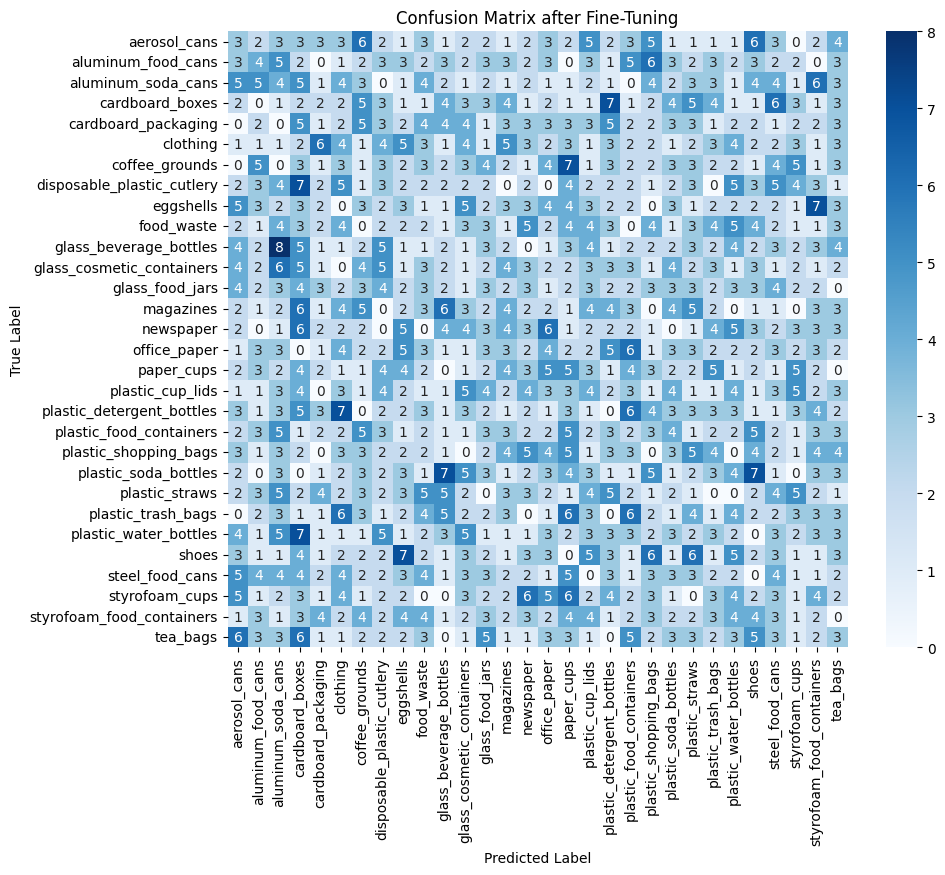

In [108]:
# Evaluate the fine-tuned model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy after fine-tuning: {test_accuracy}')
print(f'Test Loss after fine-tuning: {test_loss}')

# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix for analysis
conf_matrix = confusion_matrix(test_generator.classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix after Fine-Tuning')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

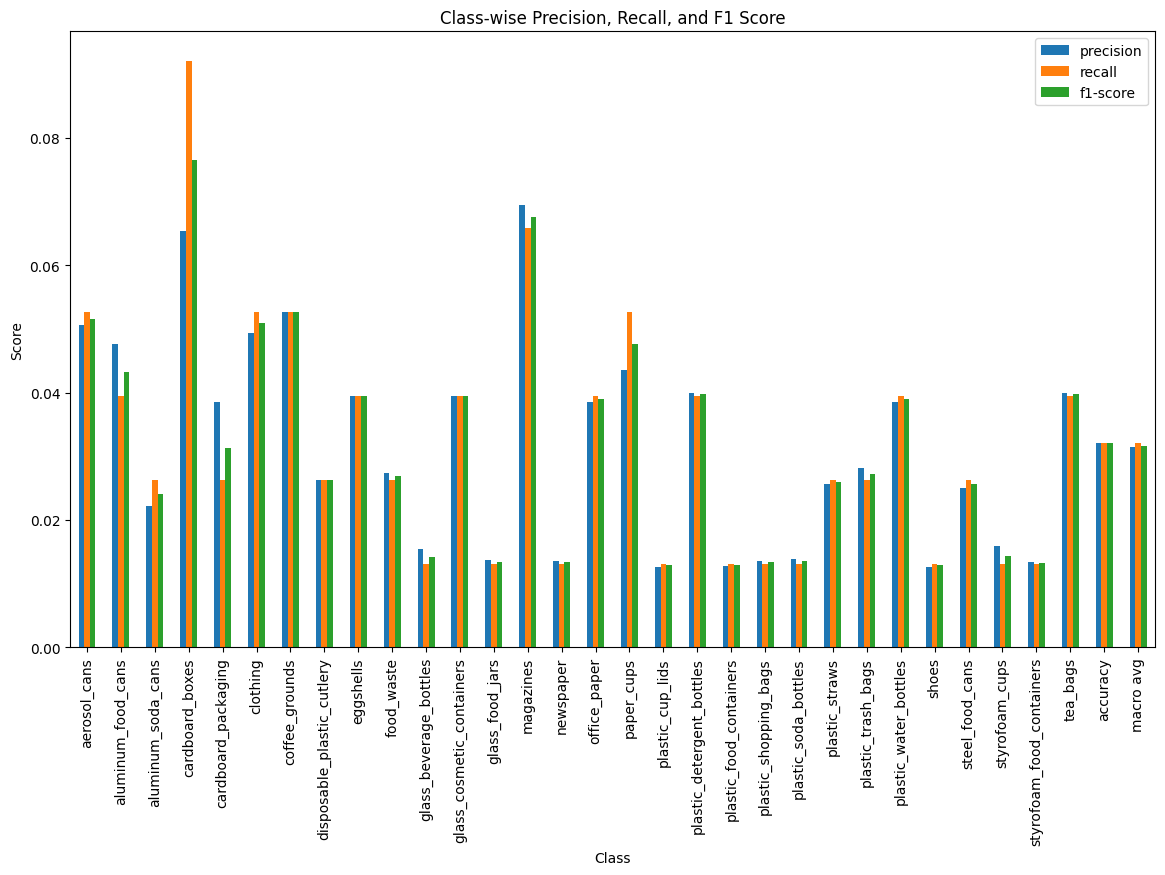

In [107]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(test_generator.classes, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot Precision, Recall, and F1 Score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(14, 8))
plt.title('Class-wise Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Load the model
model = load_model('Recyclable_image_processing\cnn_best_model.keras')

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    'Recyclable_image_processing/images/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print('Classification Report')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()